In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
from obspy import UTCDateTime
from obspy.clients.fdsn.client import Client
from tqdm import tqdm
import logging

In [177]:
client = Client("IRIS")
starttime = UTCDateTime("2000-01-01T00:00:00")
endtime = UTCDateTime("2023-01-01T00:00:00")
indo_coords = dict(minlatitude=-11, maxlatitude=6, minlongitude=95, maxlongitude=141)
maxrad = 10
maxdepth = 5
year = starttime.strftime('%Y')
endyear = endtime.strftime('%Y')

In [171]:
cat = client.get_events(
    starttime=starttime, endtime=endtime, 
    mindepth=0.05, maxdepth=maxdepth, minmagnitude=2, **indo_coords
    )

event_dict = {'id':[], 'origin_time': [], 'latitude': [], 'longitude': [], 'depth': [], 'magnitude':[], 'magnitude_type':[]}
for ev in cat.events[1:]:
    ev_id = str(ev.resource_id).split('=')[-1]
    event_dict["id"].append(ev_id)
    event_dict["origin_time"].append(ev.origins[0].time)
    event_dict["latitude"].append(ev.origins[0].latitude)
    event_dict["longitude"].append(ev.origins[0].longitude)
    event_dict["depth"].append(ev.origins[0].depth/1000)
    event_dict["magnitude"].append(ev.magnitudes[0].mag)
    event_dict["magnitude_type"].append(ev.magnitudes[0].magnitude_type)
    
df_ev = pd.DataFrame(event_dict)
df_ev.to_csv(f'../data/indonesia/{year}.{endyear}.{maxdepth}.{maxrad}.metadata_iris.csv', index=False)

cat

874 Event(s) in Catalog:
2022-10-06T20:00:38.582000Z |  +1.923,  +98.870 | 4.9  mb
2022-03-29T13:35:11.162000Z |  -2.257, +139.227 | 4.3  mb
...
2000-01-02T18:30:58.700000Z | -10.655, +119.888 | 4.6  ML
2000-01-01T02:25:43.000000Z |  -2.375, +140.520 | 4.8  MD
To see all events call 'print(CatalogObject.__str__(print_all=True))'

In [172]:
df_ev = pd.read_csv(f'../data/indonesia/{year}.{endyear}.{maxdepth}.{maxrad}.metadata_iris.csv')
df_ev

,id,origin_time,latitude,longitude,depth,magnitude,magnitude_type
0,11546114,2022-03-29T13:35:11.162000Z,-2.2574,139.2275,5.00,4.3,mb
1,11542346,2022-03-14T04:43:31.807000Z,-5.8900,102.8373,4.86,4.5,mb
2,11532818,2022-02-25T01:39:26.723000Z,0.2140,100.0895,4.94,6.1,mww
3,11524952,2022-01-08T17:07:09.034000Z,1.5215,127.8641,4.72,4.4,mb
4,11452264,2021-07-10T17:59:03.432000Z,0.6597,120.6466,3.44,4.0,mb
...,...,...,...,...,...,...,...
868,887078,2000-01-06T14:44:56.700000Z,-1.0719,139.8038,2.00,4.0,ML
869,879746,2000-01-04T03:48:31.100000Z,-2.0827,140.4176,2.00,5.1,MD
870,877037,2000-01-03T03:00:15.400000Z,-9.3834,115.1686,2.00,4.9,ML
871,875939,2000-01-02T18:30:58.700000Z,-10.6550,119.8880,2.00,4.6,ML


In [178]:
station_dict = {'network':[], 'station':[], 'latitude':[], 'longitude':[], 'event_id': []}
event_get_station_error = []
for i, row in tqdm(list(df_ev.iterrows())[:], f'get near station from events with {maxrad} degree'):
    try:
        inv = client.get_stations(network="*", station="*", channel="BH?", latitude=row['latitude'], longitude=row['longitude'], maxradius=maxrad)
        for net in inv:
            for sta in net:
                if sta.code not in station_dict['station']:
                    station_dict['network'].append(net.code)
                    station_dict['station'].append(sta.code)
                    station_dict['latitude'].append(sta.latitude)
                    station_dict['longitude'].append(sta.longitude)
                    station_dict['event_id'].append([row.id])
                else:
                    sid = station_dict['station'].index(sta.code)
                    ev_id = station_dict['event_id'][sid]
                    if row.id not in ev_id:
                        ev_id.append(row.id)  
    except Exception as e:
        df_ev = df_ev.drop(i)
        event_get_station_error.append(f'{row.id}: {e}')
        # print(f'{row.id}: {e}')

print(f'total station before availability check: {len(station_dict["station"])}')

df_sta = pd.DataFrame(station_dict)
df_sta['sum_ev'] = df_sta.event_id.apply(lambda x: len(x))
df_sta['event_id'] = df_sta.event_id.apply(tuple)
df_sta = df_sta.sort_values(by='sum_ev', ascending=False).reset_index(drop=True)
df_sta.to_csv(f'../data/indonesia/{year}.{endyear}.{maxdepth}.{maxrad}.stations.csv',index=False)

df_sta

get near station from events with 10 degree: 100%|██████████| 869/869 [08:59<00:00,  1.61it/s]

total station before availability check: 239


,network,station,latitude,longitude,event_id,sum_ev
0,II,KAPI,-5.01420,119.751700,"(11452264, 11436669, 11145533, 11116953, 10961...",499
1,YS,SINA,-8.18380,122.912400,"(11452264, 11436669, 11116953, 11038108, 10961...",482
2,YS,BKOR,-8.48680,122.550900,"(11452264, 11436669, 11116953, 11038108, 10961...",477
3,GE,MMRI,-8.63570,122.237602,"(11452264, 11436669, 11116953, 11038108, 10961...",470
4,GE,JAGI,-8.47020,114.152100,"(10961409, 10943193, 10763970, 10597128, 51937...",466
...,...,...,...,...,...,...
234,TM,SRDT,14.39480,99.121300,"(2774655,)",1
235,7B,SA01,-13.95860,143.180099,"(1904019,)",1
236,AU,COEN,-13.95740,143.174896,"(1904019,)",1
237,ZN,WANI,-9.33780,149.154694,"(1103059,)",1


In [185]:
no_wave_station = []
def check_avail(df):
    logging.basicConfig(filename='errors.log', level=logging.ERROR, filemode='w')
    df_sta = df.copy()
    for i, row in tqdm(list(df_sta.iterrows())[:], f'check station availability'):
        if row.station not in no_wave_station:
            try:
                client.get_waveforms(
                    network=row.network, station=row.station, location="*",
                    channel='BH?', starttime=endtime, endtime=endtime+1)
            except Exception as e:
                logging.error(f'{row.network}.{row.station} | {e}')
                no_wave_station.append(row.station)
                df_sta = df_sta.drop(i)

    print(f'total unavailable requested data: {len(no_wave_station)}')
    logging.shutdown()
    return df_sta.reset_index(drop=True)

In [186]:
# df_sta = pd.read_csv(f'../data/indonesia/stations.{year}.{endyear}.{maxdepth}.{maxrad}.csv')
df_sta_av = check_avail(df_sta)
df_sta_av.to_csv(f'../data/indonesia/{year}.{endyear}.{maxdepth}.{maxrad}.stations_filtered.csv',index=False)
# df_sta_av = pd.read_csv(f'../data/indonesia/stations.{year}.{endyear}.{maxdepth}.{maxrad}_filtered.csv')

print(f'potential total events data: {df_sta_av.sum_ev.sum()}')
df_sta_av

check station availability: 100%|██████████| 239/239 [02:53<00:00,  1.37it/s]


total unavailable requested data: 235
potential total events data: 1217


,network,station,latitude,longitude,event_id,sum_ev
0,II,KAPI,-5.0142,119.751700,"(11452264, 11436669, 11145533, 11116953, 10961...",499
1,GE,UGM,-7.9125,110.523102,"(11542346, 11139123, 10943193, 10763970, 51937...",424
2,IU,DAV,7.0697,125.579100,"(11524952, 11452264, 11436669, 11149644, 11145...",176
3,PS,PSI,2.6938,98.923698,"(11542346, 11532818, 11304660, 11139123, 99981...",118


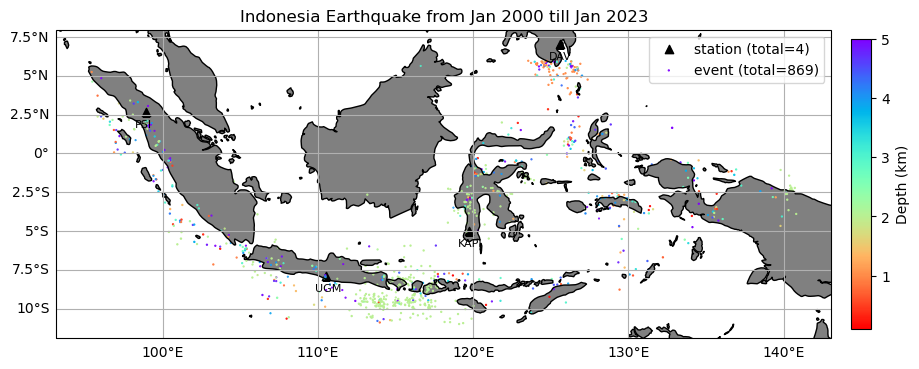

In [182]:
import matplotlib.axes as axes

metadata_sta = df_sta_av
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree()))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels=False
gl.right_labels=False

ax.add_feature(cfeature.LAND, facecolor='gray')
ax.add_feature(cfeature.COASTLINE)
stas = ax.scatter(metadata_sta.longitude, metadata_sta.latitude, transform=ccrs.PlateCarree(), color='k', marker='^', label=f'station (total={len(metadata_sta)})')
# Add station names using the annotate function
for i, station in enumerate(metadata_sta.station):
    ax.annotate(station, xy=(metadata_sta['longitude'][i], metadata_sta['latitude'][i]), xytext=(-8, -11), textcoords='offset points', fontsize=8)


evs = ax.scatter(df_ev.longitude, df_ev.latitude, transform=ccrs.PlateCarree(), s=.1*df_ev.magnitude, c=df_ev.depth, cmap='rainbow_r', label=f'event (total={len(df_ev)})')
plt.legend()
times = [starttime.strftime('%b %Y'), endtime.strftime('%b %Y')]
plt.title(f'Indonesia Earthquake from {times[0]} till {times[1]}')

# Manually create a new axis for the colorbar
cax = fig.add_axes([0.92, 0.35, 0.02, 0.29])

# Add the colorbar to the new axis
cbar = fig.colorbar(evs, cax=cax)
cbar.set_label('Depth (km)')


In [190]:
events_stations = []
for _, sta in df_sta_av.iterrows():
    se = sta.event_id if type(sta.event_id) != str else [int(s) for s in sta.event_id[1:-1].split(',')]
    for ev_id in se:
        events_stations.append((sta, df_ev[df_ev.id == ev_id].iloc[0])) 

len(events_stations)

1217

In [265]:
1/0.04

25.0

In [266]:
from obspy.taup import TauPyModel
import multiprocessing
import pandas as pd
import numpy as np
from obspy.geodetics import gps2dist_azimuth, locations2degrees
from tqdm import tqdm

tau = 'prem'
model = TauPyModel(model=tau)

def calculate_travel_time(sta, ev):
    dist = locations2degrees(ev.latitude, ev.longitude, sta.latitude, sta.longitude)
    p_arrivals = model.get_travel_times(source_depth_in_km=ev.depth, distance_in_degree=dist, phase_list=['P','p'])
    
    if len(p_arrivals) > 0:
        s_arrivals = model.get_travel_times(source_depth_in_km=ev.depth, distance_in_degree=dist, phase_list=['S','s'])

        if len(s_arrivals) > 0:
            p_ = min(p.time for p in p_arrivals)
            s_ = min(s.time for s in s_arrivals)
            coda_ = s_ + 1.4*(s_-p_) + (1/dist)

            origin_time = UTCDateTime(ev.origin_time)
            data = np.array([f'ev_{ev.id}.{sta.network}.{sta.station}', origin_time, origin_time + p_, origin_time + s_, origin_time + coda_, 
                             ev.latitude, ev.longitude, ev.depth, ev.magnitude, ev.magnitude_type, 
                             dist, sta.network, sta.station, sta.latitude, sta.longitude])
            return data
        else: 
            print(f'{ev.id} | {sta.station} not have s arrivals')
            return None
    else:
        print(f'{ev.id} | {sta.station} not have p arrivals')
        return None

columns = ['id', 'origin_time', 'p_arrival', 's_arrival', 'coda', 
            'event_latitude', 'event_longitude', 'event_depth', 'magnitude', 'magnitude_type', 
            'distance_in_degree', 'network', 'station', 'station_latitude', 'station_longitude']
if __name__=='__main__':
    data = []
    for sta, ev in tqdm(events_stations, f'get travel time on each events'):
        result = calculate_travel_time(sta, ev)
        if result is not None:
            data.append(result)

    df = pd.DataFrame(data, columns=columns)
    df = df.sort_values(by='distance_in_degree').reset_index(drop=True)
    df.to_csv(f'../data/indonesia/{year}.{endyear}.{maxdepth}.{maxrad}.chunk_ev.csv', index=False)

df

get travel time on each events: 100%|██████████| 1217/1217 [00:51<00:00, 23.58it/s]


,id,origin_time,p_arrival,s_arrival,coda,event_latitude,event_longitude,event_depth,magnitude,magnitude_type,distance_in_degree,network,station,station_latitude,station_longitude
0,ev_3680115.GE.UGM,2009-04-28T01:10:23.300000Z,2009-04-28T01:10:24.278652Z,2009-04-28T01:10:25.073807Z,2009-04-28T01:10:49.257709Z,-7.9200,110.4800,3.00,3.3,MLv,0.043345,GE,UGM,-7.9125,110.523102
1,ev_2303169.GE.UGM,2006-05-27T03:10:02.550000Z,2006-05-27T03:10:04.109731Z,2006-05-27T03:10:05.377013Z,2006-05-27T03:10:21.117191Z,-7.9189,110.4511,4.30,4.8,mb,0.071603,GE,UGM,-7.9125,110.523102
2,ev_4508881.GE.UGM,2008-08-29T01:03:16.000000Z,2008-08-29T01:03:17.920867Z,2008-08-29T01:03:19.481571Z,2008-08-29T01:03:32.830776Z,-7.8400,110.4700,5.00,3.1,MLv,0.089572,GE,UGM,-7.9125,110.523102
3,ev_3780862.GE.UGM,2009-08-12T08:27:54.600000Z,2009-08-12T08:27:56.753308Z,2009-08-12T08:27:58.502871Z,2009-08-12T08:28:10.347671Z,-8.0100,110.4800,4.00,3.0,MLv,0.106435,GE,UGM,-7.9125,110.523102
4,ev_4508484.GE.UGM,2008-08-28T11:46:14.000000Z,2008-08-28T11:46:16.283242Z,2008-08-28T11:46:18.138376Z,2008-08-28T11:46:29.540835Z,-8.0000,110.4500,4.00,3.0,MLv,0.113568,GE,UGM,-7.9125,110.523102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,ev_4023811.IU.DAV,2010-05-15T14:28:44.800000Z,2010-05-15T14:31:05.951713Z,2010-05-15T14:32:59.456664Z,2010-05-15T14:35:38.463948Z,-1.2427,120.0714,0.30,3.9,mb,9.964879,IU,DAV,7.0697,125.579100
1213,ev_11139123.GE.UGM,2019-10-30T22:26:32.349000Z,2019-10-30T22:28:53.235020Z,2019-10-30T22:30:46.520127Z,2019-10-30T22:33:25.219490Z,-4.4266,101.1171,4.04,4.4,mb,9.978592,GE,UGM,-7.9125,110.523102
1214,ev_3693855.GE.UGM,2009-05-12T12:36:47.200000Z,2009-05-12T12:39:08.222838Z,2009-05-12T12:41:01.619829Z,2009-05-12T12:43:40.475824Z,-3.4000,119.4700,3.00,3.2,MLv,9.979393,GE,UGM,-7.9125,110.523102
1215,ev_921963.GE.UGM,2000-03-19T08:44:15.100000Z,2000-03-19T08:46:36.409197Z,2000-03-19T08:48:30.038604Z,2000-03-19T08:51:09.219860Z,-3.8634,119.7079,2.00,4.3,MD,9.991507,GE,UGM,-7.9125,110.523102


get and save to h5 each event waveforms:   0%|          | 0/1217 [00:00<?, ?it/s]

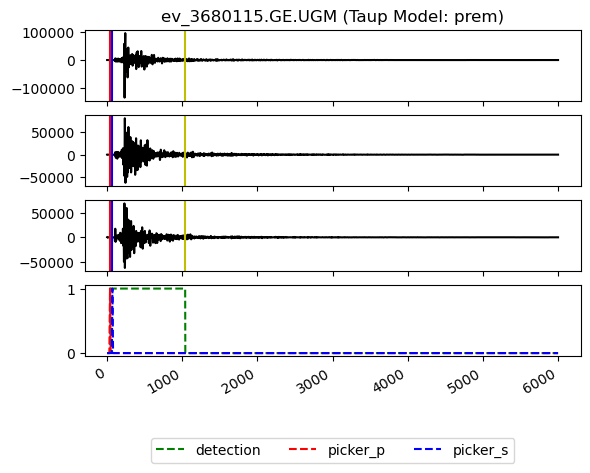

get and save to h5 each event waveforms:   4%|▍         | 50/1217 [01:45<44:57,  2.31s/it]  

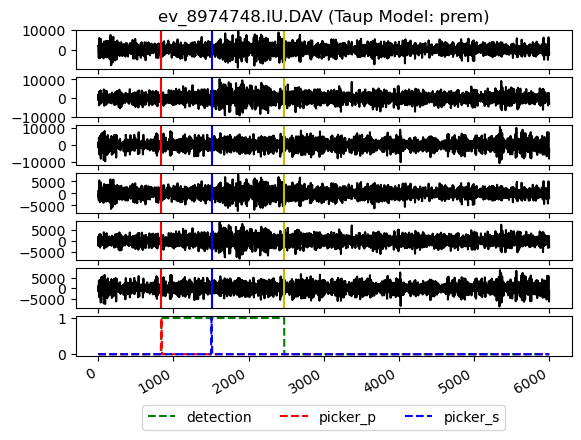

get and save to h5 each event waveforms:   8%|▊         | 100/1217 [03:33<59:14,  3.18s/it]

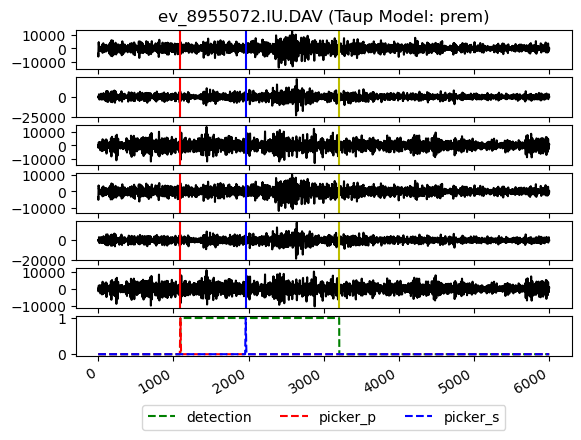

get and save to h5 each event waveforms:  12%|█▏        | 150/1217 [05:33<30:09,  1.70s/it]  

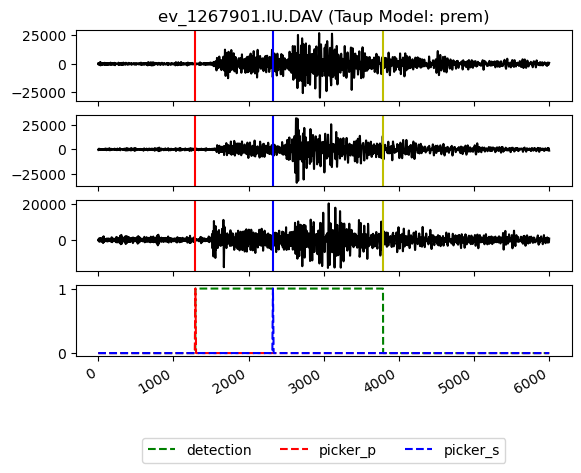

get and save to h5 each event waveforms:  16%|█▋        | 200/1217 [07:01<25:33,  1.51s/it]

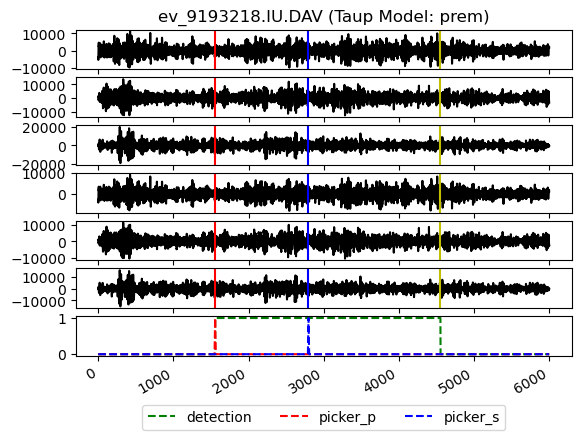

get and save to h5 each event waveforms:  21%|██        | 250/1217 [08:17<27:56,  1.73s/it]

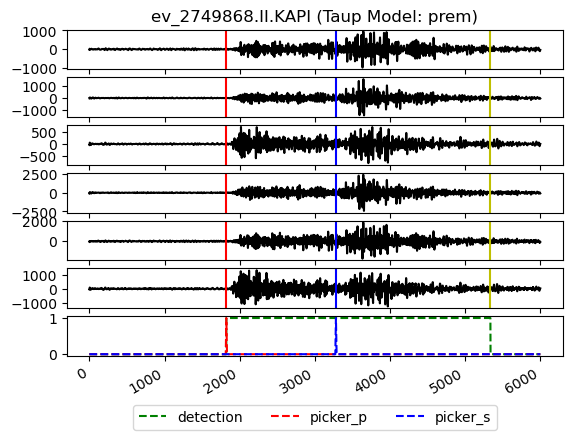

get and save to h5 each event waveforms:  25%|██▍       | 300/1217 [09:39<23:34,  1.54s/it]

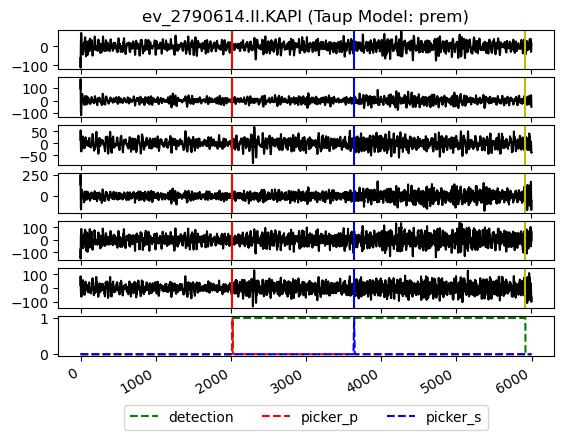

get and save to h5 each event waveforms:  29%|██▉       | 350/1217 [10:58<24:02,  1.66s/it]

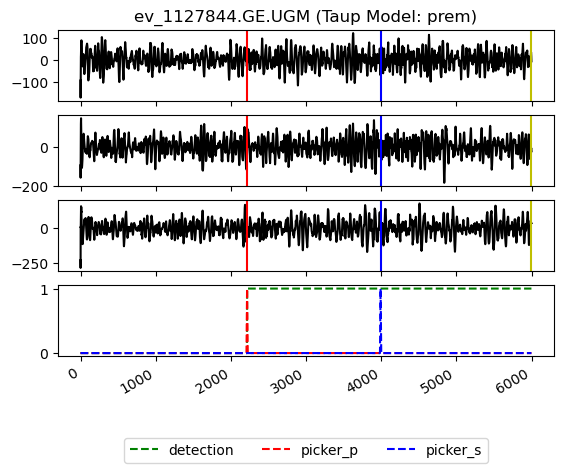

get and save to h5 each event waveforms:  37%|███▋      | 450/1217 [13:18<19:56,  1.56s/it]

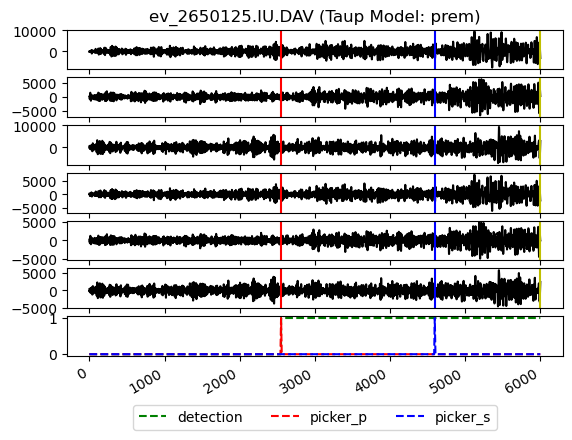

get and save to h5 each event waveforms:  45%|████▌     | 550/1217 [15:42<16:08,  1.45s/it]

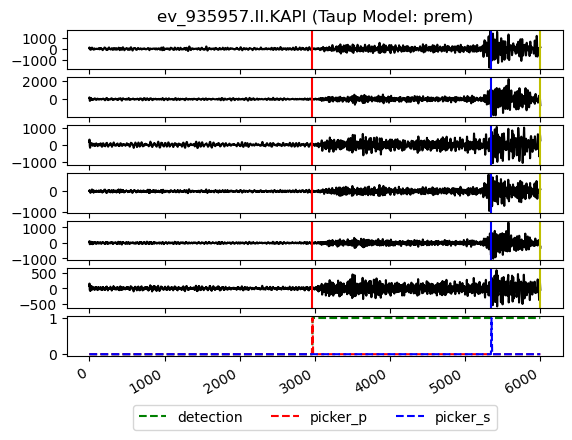

get and save to h5 each event waveforms:  49%|████▉     | 600/1217 [16:56<13:44,  1.34s/it]

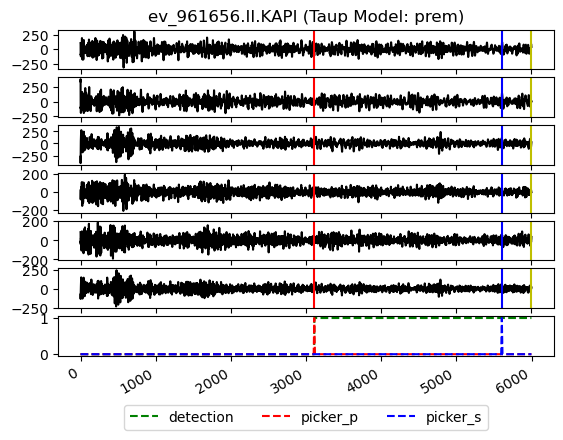

get and save to h5 each event waveforms:  53%|█████▎    | 650/1217 [18:13<18:41,  1.98s/it]

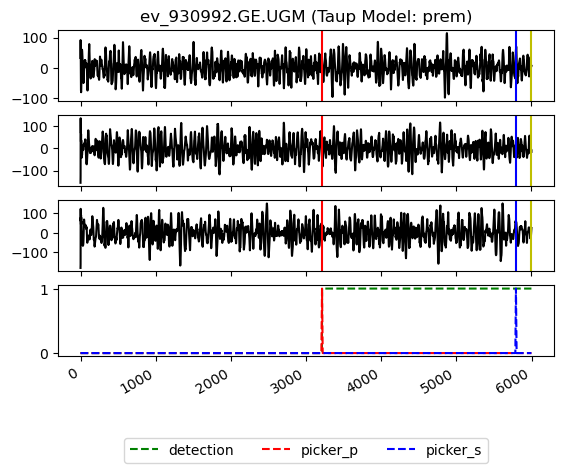

get and save to h5 each event waveforms:  90%|████████▉ | 1092/1217 [31:05<03:33,  1.71s/it]


KeyboardInterrupt: 

In [268]:
import h5py, os
from datetime import datetime


new_data = []
new_columns = [*columns, *['starttime', 'endtime', 'p_', 's_', 'coda_', 'component']]
TIMESTEPS = 6000
PLOTSTEP = 50
h5_path = f'../data/indonesia/{year}.{endyear}.{maxdepth}.{maxrad}.chunk_indo.hdf5'

logging.shutdown()

# Configure the logger
logging.basicConfig(filename='errors.log', level=logging.ERROR, filemode='w')

rendered_data = list(df.iterrows())
except_events = []
with h5py.File(h5_path, 'w') as h5:
    for e, evs in tqdm(rendered_data[:], 'get and save to h5 each event waveforms'):
        try:
            kwargs = dict(
                    network=evs.network, station=evs.station, location="*",
                    channel='BH?', starttime=evs.origin_time, endtime=evs.coda+(600/evs.distance_in_degree)
                    )
            st = client.get_waveforms(**kwargs)
            sr = st[0].stats.sampling_rate
            
            if sr != 40:
                st.resample(40)
            assert len(st)%3 == 0, f'{evs.id} | this data have {len(st)} traces, cannot split to 3 component'
            
            if (len(st)%3 == 0):
                st.detrend("linear")
                st.filter('bandpass', freqmin=1, freqmax=18)

                duration = (st[0].stats.endtime - st[0].stats.starttime)
                p_arr = evs.p_arrival
                s_arr = evs.s_arrival
                
                start_trim = p_arr - (evs.p_arrival - evs.origin_time) // 5
                end_trim = start_trim + (TIMESTEPS+1)/40

                st.trim(start_trim, end_trim)
                assert st[0].stats.npts >= 6000, f'{evs.id} | this data just trim to {st[0].stats.npts} sample'

                times = st[0].times('timestamp')
                p_ = np.abs(times-p_arr.timestamp).argmin()
                s_ = np.abs(times-s_arr.timestamp).argmin()
                coda_ = np.abs(times-evs.coda.timestamp).argmin()

                pp = np.zeros((TIMESTEPS,))
                sp = np.zeros((TIMESTEPS,))
                eqp = np.zeros((TIMESTEPS,))
                
                # Set the values of eqp to 1 between p_ and coda_
                eqp[p_:coda_+1] = 1.

                n = 8
                # Calculate the triangular waveform for pp
                pp[p_-n:p_+1] = np.linspace(0,1,n+1)
                pp[p_:p_+n+1] = np.linspace(1,0,n+1)
                
                # Calculate the triangular waveform for sp
                sp[s_-n:s_+1] = np.linspace(0,1,n+1)
                sp[s_:s_+n+1] = np.linspace(1,0,n+1)

                for s in range(len(st)//3):
                    new_evs = evs.copy()
                    new_evs.id = f'{evs.id}.{st[s*3].stats.location}'
                    tr3 = st[s*3:(s+1)*3]
                    channel = ','.join([t.stats.channel for t in tr3])

                    new_values = np.array([*new_evs.values, *[st[0].stats.starttime,st[0].stats.endtime, p_, s_, coda_, channel]])
                    new_data.append(new_values)

                    data_ = np.array([t.data for t in tr3])
                    out_ = np.array([pp,sp,eqp])
                    dset = h5.create_dataset(f'{new_evs.id}/data', data=data_[:6000], chunks=True, compression='gzip')
                    oset = h5.create_dataset(f'{new_evs.id}/output', data=out_, chunks=True, compression='gzip')

                    time_key = ['origin_time','p_arrival','s_arrival','coda','starttime','endtime']
                    for key, val in zip(new_columns, new_values):
                        dset.attrs[key] = val if key not in time_key else str(val)

                # plot random data
                if (e in np.arange(0, len(df), PLOTSTEP)):
                    fig, ax = plt.subplots(len(st)+1)
                    ax[0].set_title(f'{evs.id} (Taup Model: {tau})')
                    for i, tr in enumerate(st):
                        ax[i].plot(tr.data, 'k')
                        ax[i].axvline(x=p_, color='r')
                        ax[i].axvline(x=s_, color='b')
                        ax[i].axvline(x=coda_, color='y')

                    ax[len(st)].plot(eqp, 'g--', label='detection')
                    ax[len(st)].plot(pp, 'r--', label='picker_p')
                    ax[len(st)].plot(sp, 'b--', label='picker_s')
                    fig.autofmt_xdate()
                    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -1.05), ncol=3)
                    plt.show()
            
        except Exception as e:
            except_events.append(evs.id)
            logging.error(f'{UTCDateTime(datetime.now())} - {evs.id} | {e}')


df_indo = pd.DataFrame(new_data, columns=new_columns)
df_indo.to_csv(f'../data/indonesia/{year}.{endyear}.{maxdepth}.{maxrad}.metadata_indo.csv', index=False)

In [297]:
(evs.p_arrival - evs.origin_time) // 5

25.0

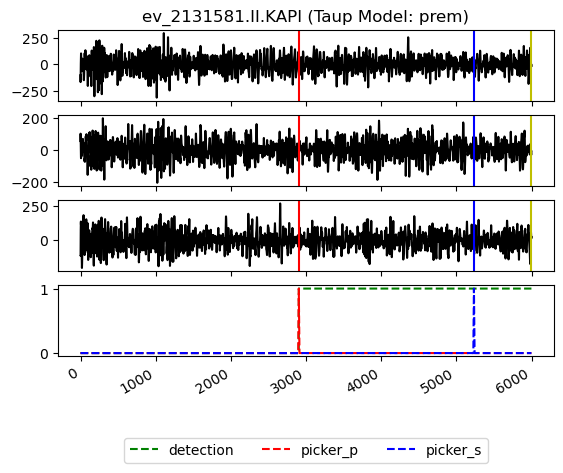

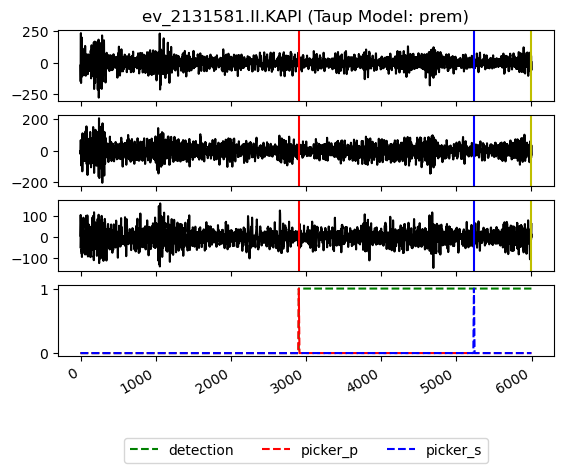

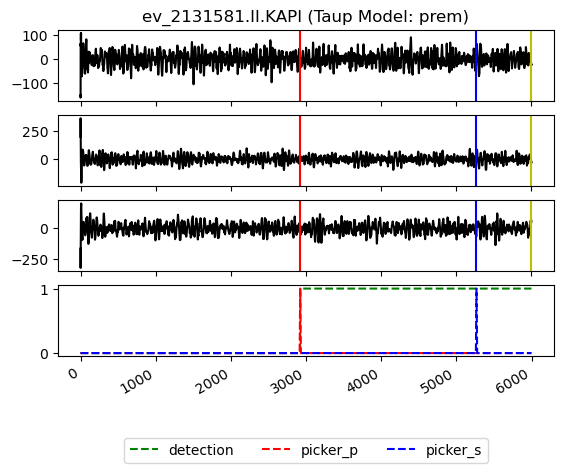

In [287]:
metadata = pd.read_csv(f'../data/indonesia/{year}.{endyear}.{maxdepth}.{maxrad}.metadata_indo.csv')

for id in metadata[metadata.distance_in_degree < 5].id[-3:]:
    with h5py.File(h5_path, 'r') as r:
        dt = r.get(id)
        data = dt['data']
        output = dt['output']

        fig, ax = plt.subplots(len(data)+1)
        ax[0].set_title(f'{evs.id} (Taup Model: {tau})')
        for i, tr in enumerate(data):
            ax[i].plot(tr, 'k')
            ax[i].axvline(x=data.attrs['p_'], color='r')
            ax[i].axvline(x=data.attrs['s_'], color='b')
            ax[i].axvline(x=data.attrs['coda_'], color='y')

        ax[len(data)].plot(output[2], 'g--', label='detection')
        ax[len(data)].plot(output[0], 'r--', label='picker_p')
        ax[len(data)].plot(output[1], 'b--', label='picker_s')
        fig.autofmt_xdate()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -1.05), ncol=3)
        plt.show()
        
